In [1]:
%matplotlib inline

# Define external functions
%run influx-fetcher.py


import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from fbprophet import Prophet
from workalendar.europe import Sweden
from datetime import timedelta
import datetime

Influx fetcher loaded


In [2]:
# Evaluate labels
import ast
fd = open('2018-06-27_14-50-04.labels')
labels_timestamps = ast.literal_eval(file.read(fd))
print labels_timestamps

[[1530111004, u'low'], [1530113068, u'high'], [1530114024, u'low'], [1530116079, u'middle'], [1530117293, u'middle'], [1530118496, u'middle'], [1530119712, u'low'], [1530121777, u'middle'], [1530122997, u'low'], [1530125056, u'low'], [1530127111, u'high'], [1530128060, u'middle'], [1530129290, u'low'], [1530131369, u'middle'], [1530132610, u'low'], [1530134693, u'low'], [1530136771, u'low'], [1530138857, u'high'], [1530139849, u'low'], [1530141924, u'middle'], [1530143156, u'high'], [1530144148, u'middle'], [1530145382, u'low'], [1530147448, u'high'], [1530148430, u'low'], [1530150518, u'middle'], [1530151752, u'low'], [1530153815, u'low'], [1530155877, u'high'], [1530156859, u'middle'], [1530158022, u'middle'], [1530159158, u'high'], [1530160051, u'high'], [1530160916, u'middle'], [1530162036, u'high'], [1530162925, u'low'], [1530164942, u'middle']]


In [3]:
from datetime import datetime 

# Get data from database
# node_cpu_norm = getInfluxData('192.168.104.186', 'node_cpu_norm')

conf = InfluxConfig(ip = "212.32.186.84")
metric = {
    'metrics': [
                   {
                        'name': 'istio_request_count',
                        'flags': {
                            'nonNegRate': True,
                            'group': ["destination_service", "source_service"],
                            'normalize': True
                        } 
                    }
                ],
    'times': {
        'startTime': "1530111004s",
        'stopTime':  "1530165650s"
    },
    'groupTime': "30s"
}
data = get_metrics(metric, conf)
node_cpu_norm = data['data']
feature_names = data['feature_names']
times = data['times']

#y = [0] * len(node_cpu_norm)
#for label in labels_timestamps:
#    time = datetime.fromtimestamp(label[0])
#    level = label[1]
#    for i, data_time in enumerate(times):
#        if time <= data_time:
#            if level == 'high':
#                y[i] = 2
#            elif level == 'middle':
#                y[i] = 1
#            elif level == 'low':
#                y[i] = 0

"""
                    {
                        'name': 'node_cpu_norm',
                        'flags': {
                            'rate': True,
                            'group': ["instance"]
                        }
                    }, {
                        'name': 'istio_request_count',
                        'flags': {
                            'nonNegRate': True,
                            'group': ["destination_service", "source_service"],
                            'normalize': True
                        } 
                    }, {
                        'name': 'istio_tcp_bytes_received',
                        'flags': {
                            'nonNegRate': True,
                            'group': ["destination_service", "source_service"],
                            'normalize': True
                        }
                    }, {
                        'name': 'cluster_percent_non_5xx',
                        'flags': {
                            'group': ["instance"],
                            'fill': True
                        }
                    }, {
                        'name': 'node_percent_mem_free',
                        'flags': {
                            'group': ["instance"],
                            'fill': True
                        }
                    }, {
                        'name': 'envoy_http_http_downstream_rq_time',
                        'flags': {
                            'group': ["quantile"],
                            'normalize': True,
                            'fill': True
                        }
                    }, {
                        'name': '/envoy_cluster_inbound_\d+__.*_sock_shop_svc_cluster_local_upstream_cx_connect_ms/',
                        'flags': {
                            'group': ["__name__"],
                            'nonNegRate': True,
                            'normalize': True
                        }
                    }
"""

Querying: SELECT non_negative_derivative(mean("f64"), 1s) AS "data_value" FROM "_" WHERE (("__name__" = 'istio_request_count') AND (time >= 1530111004s) AND (time <= 1530165650s)) GROUP BY time(30s), destination_service, source_service fill(linear)
Merging data
Lost 0% of data


'\n                    {\n                        \'name\': \'node_cpu_norm\',\n                        \'flags\': {\n                            \'rate\': True,\n                            \'group\': ["instance"]\n                        }\n                    }, {\n                        \'name\': \'istio_request_count\',\n                        \'flags\': {\n                            \'nonNegRate\': True,\n                            \'group\': ["destination_service", "source_service"],\n                            \'normalize\': True\n                        } \n                    }, {\n                        \'name\': \'istio_tcp_bytes_received\',\n                        \'flags\': {\n                            \'nonNegRate\': True,\n                            \'group\': ["destination_service", "source_service"],\n                            \'normalize\': True\n                        }\n                    }, {\n                        \'name\': \'cluster_percent_non_5

In [4]:

ds = []
for i, tim in enumerate(times):
    newTime = tim + timedelta(hours=i*1)
    ds.append(newTime)
        
#y = np.array(node_cpu_norm)[:,2]
y = np.array(node_cpu_norm)[:,0]
for i, tmp in enumerate(y):
    y[i] = y[i] * 5 - 0.5
tt = np.column_stack([y.tolist()])
data = pd.DataFrame(data=tt.tolist(),
                    index=ds,
                    columns=['y'])
#data["y"].apply(lambda x: (x + 1) * 4)
#data["y"] = np.log(data['y'])
data = data.resample("70T").mean()
data["ds"] = data.index
df = data.copy()

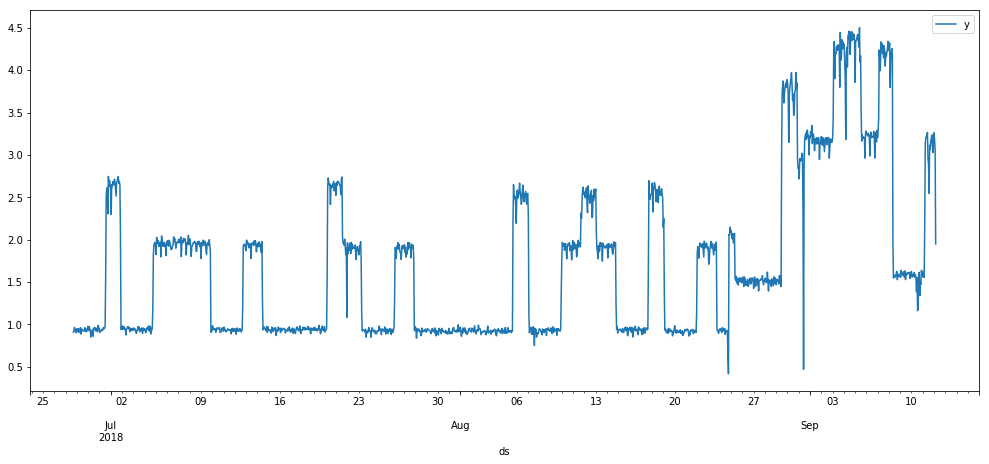

In [5]:
# Plot the data
data.plot(x="ds", y="y", figsize=(17,7))

In [7]:
# periods * freq points into the future
periods = 600
freq = 'H'

holidays = generate_holidays(df, periods, freq)
m, df = build_model(df, holidays)
# Train/fit the model
m.fit(df)

future = build_future(m, periods, freq)

INFO:fbprophet.forecaster:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
/usr/local/lib/python2.7/dist-packages/pystan/misc.py:399: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  elif np.issubdtype(np.asarray(v).dtype, float):


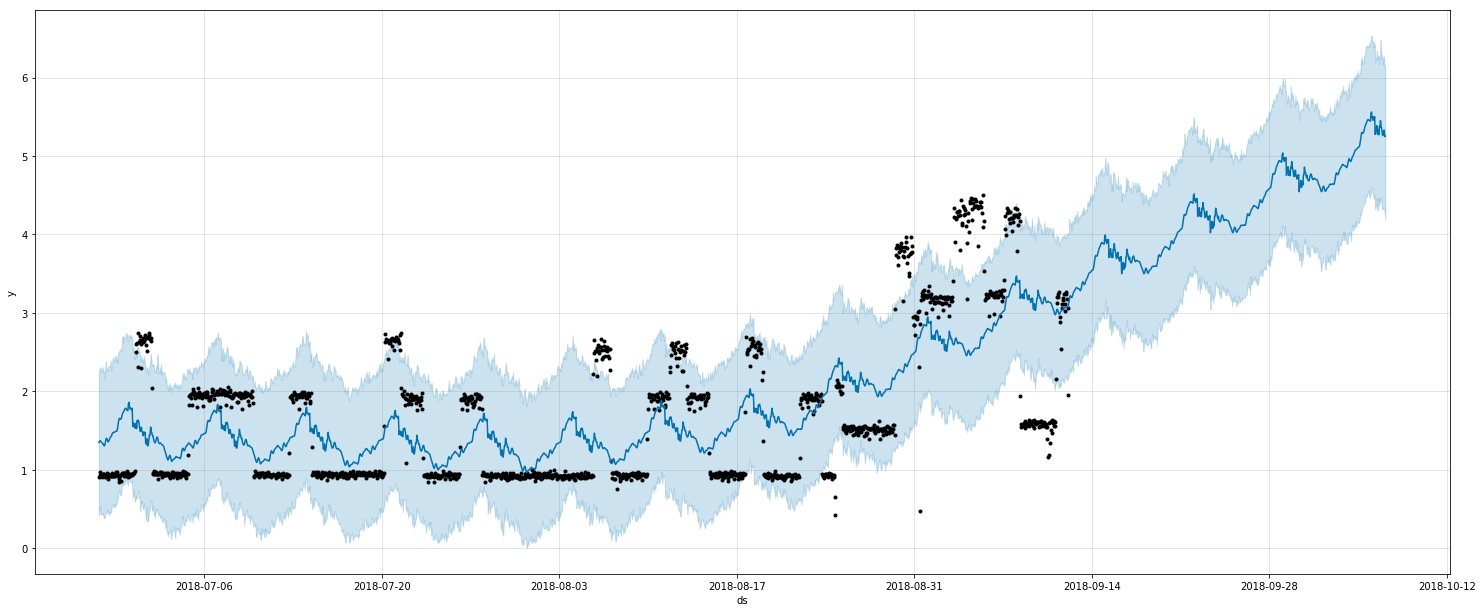

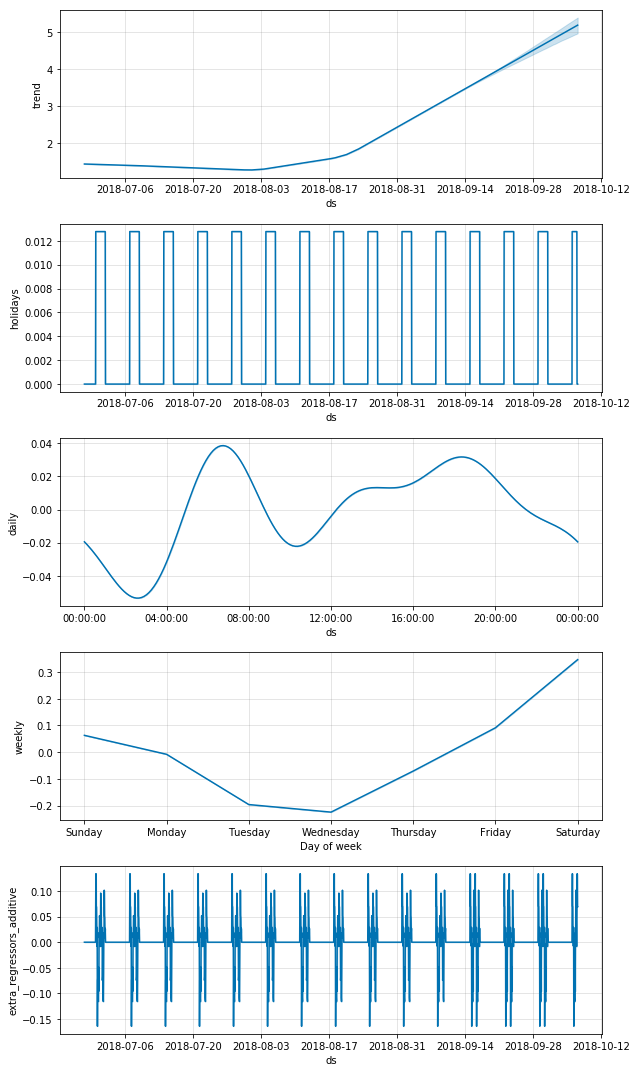

In [8]:
#forecast = get_prediction(m, future)

forecast = m.predict(future)
fig = m.plot(forecast);
fig.set_size_inches(22, 9)
m.plot_components(forecast);
forecast = forecast.set_index("ds")

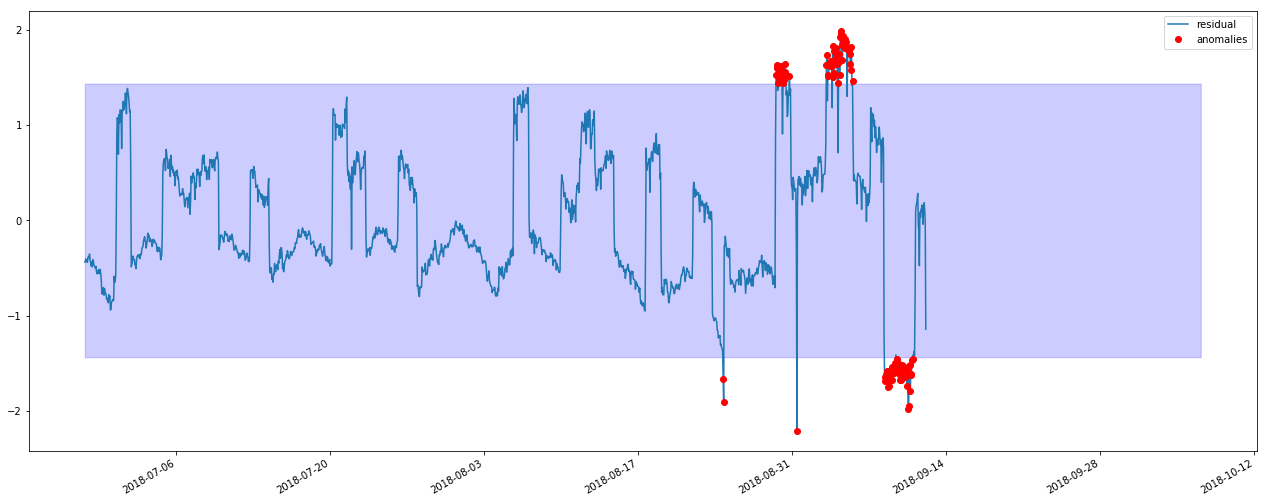

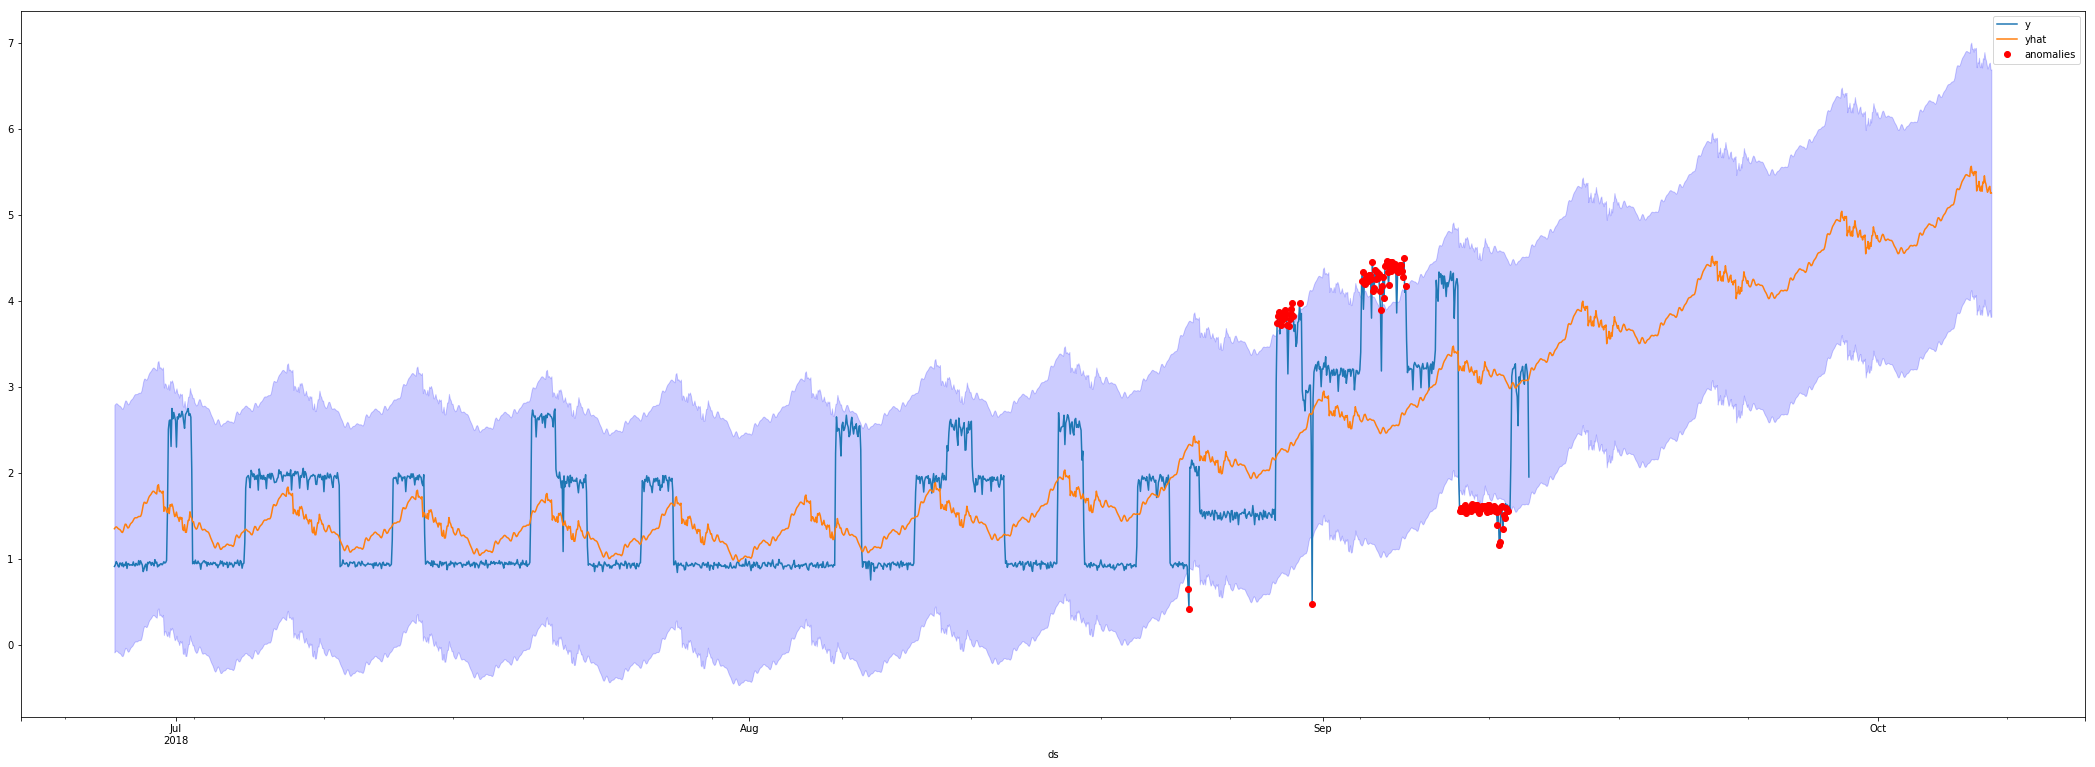

In [9]:
residual = get_residual(data, forecast)
anomalies = find_anomalies(residual)

plot_residual(residual)
plot_analysis(data, forecast)